In [56]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchvision.datasets.mnist import MNIST

import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter




def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [53]:
transform = transforms.Compose([transforms.Resize(154),
                                 transforms.CenterCrop(154),
                                 transforms.ToTensor()])
dataset = datasets.ImageFolder('../input/transformer1dataset/birds/birds', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [54]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

torch.Size([32, 3, 154, 154])


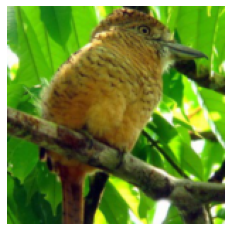

In [57]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)
print(images.shape)

In [59]:
print(dataset.class_to_idx)

{'ABBOTTS BABBLER': 0, 'ABBOTTS BOOBY': 1, 'ABYSSINIAN GROUND HORNBILL': 2, 'AFRICAN CROWNED CRANE': 3, 'AFRICAN EMERALD CUCKOO': 4, 'AFRICAN FIREFINCH': 5, 'AFRICAN OYSTER CATCHER': 6, 'ALBATROSS': 7, 'ALBERTS TOWHEE': 8, 'ALEXANDRINE PARAKEET': 9, 'ALPINE CHOUGH': 10, 'ALTAMIRA YELLOWTHROAT': 11, 'AMERICAN AVOCET': 12, 'AMERICAN BITTERN': 13, 'AMERICAN COOT': 14, 'AMERICAN GOLDFINCH': 15, 'AMERICAN KESTREL': 16, 'AMERICAN PIPIT': 17, 'AMERICAN REDSTART': 18, 'AMETHYST WOODSTAR': 19, 'ANDEAN GOOSE': 20, 'ANDEAN LAPWING': 21, 'ANDEAN SISKIN': 22, 'ANHINGA': 23, 'ANIANIAU': 24, 'ANNAS HUMMINGBIRD': 25, 'ANTBIRD': 26, 'ANTILLEAN EUPHONIA': 27, 'APAPANE': 28, 'APOSTLEBIRD': 29, 'ARARIPE MANAKIN': 30, 'ASHY THRUSHBIRD': 31, 'ASIAN CRESTED IBIS': 32, 'AVADAVAT': 33, 'AZURE JAY': 34, 'AZURE TANAGER': 35, 'AZURE TIT': 36, 'BAIKAL TEAL': 37, 'BALD EAGLE': 38, 'BALD IBIS': 39, 'BALI STARLING': 40, 'BALTIMORE ORIOLE': 41, 'BANANAQUIT': 42, 'BAND TAILED GUAN': 43, 'BANDED BROADBILL': 44, 'BANDED 

In [58]:
train_classes = [dataset.targets[i] for i in train_dataset.indices]
Counter(train_classes) # if doesn' work: Counter(i.item() for i in train_classes)

Counter({333: 135,
         273: 111,
         265: 105,
         358: 135,
         388: 112,
         227: 124,
         116: 133,
         97: 116,
         396: 189,
         177: 115,
         240: 138,
         334: 118,
         310: 161,
         304: 90,
         39: 121,
         140: 101,
         228: 110,
         2: 143,
         47: 100,
         108: 102,
         88: 125,
         123: 130,
         280: 112,
         21: 117,
         241: 122,
         45: 131,
         107: 112,
         197: 144,
         160: 116,
         326: 94,
         103: 104,
         282: 101,
         285: 97,
         390: 118,
         37: 114,
         174: 133,
         30: 113,
         36: 99,
         130: 115,
         316: 91,
         31: 119,
         389: 125,
         391: 102,
         263: 163,
         380: 106,
         119: 143,
         349: 159,
         199: 122,
         154: 122,
         144: 192,
         309: 146,
         201: 97,
         74: 140,
         288

In [ ]:
    #Training loop
    optimizer = Adam(model.parameters(), lr = LR)
    criterion = CrossEntropyLoss()
    for epoch in range(N_EPOCHS):
        train_loss = 0.0
        for batch in train_loader:
            x,y = batch
            y_hat = model(x)
            loss = criterion(y_hat,y)/len(x)
            
            train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss: .2f}")

   #Test loop
    correct, total = 0,0
    test_loss = 0.0
    for batch in test_loader:
        x,y=batch
        y_hat = model(x)
        loss = criterion(y_hat,y)
        test_loss += loss/len(x)
        
        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
        total += len(x)   
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct/total*100:.2f}%")

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        #Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch %100== 0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

In [ ]:
def main():
    transform = transforms.Compose([transforms.Resize(154),
                                 transforms.CenterCrop(154),
                                 transforms.ToTensor()])
    dataset = datasets.ImageFolder('../input/transformer1dataset/birds/birds', transform=transform)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
    
    #Model and training options
    model = BumbleBird((3,154,154), n_patches = 7, hidden_d=4, n_heads=2, out_d=400).to(device)
    N_EPOCHS = 5 # Number of epochs
    LR = 0.01 #Learning rate
    
    #Training
    optimizer = Adam(model.parameters(), lr = LR)
    criterion = CrossEntropyLoss()
    for t in range(N_EPOCHS):
        print(f"Epoch {t+1}\n-----------------------------------")
        train(train_loader, model, criterion, optimizer)
        test(test_loader, model, criterion)
    print ("Done!")  

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i/(10000**(j/d)) if j%2==0 else np.cos(i/(10000**((j-1)/d))))
    return result.to(device)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n") 
    
    
# Predictions
with torch.no_grad():
    
    transform = transforms.Compose([transforms.Resize(154),
                                 transforms.CenterCrop(154),
                                 transforms.ToTensor()])
    pred_dataset = datasets.ImageFolder('../input/transformer1dataset/submission_test', transform=transform)
    
    pred_loader = DataLoader(pred_dataset, shuffle=True, batch_size=16)
    model = BumbleBird((3,154,154), n_patches = 7, hidden_d=4, n_heads=2, out_d=400).to(device)
    arr = []
    for X, y in pred_loader:
        X, y = X.to(device), y.to(device)
        prediction = model(X)
        arr = prediction.data.cpu().detach()
    # write CSV
    np.savetxt('output.csv', arr)


In [ ]:
#Multi-head Self Attention (MSA)
class MSAtron(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MSAtron, self).__init__()
        self.d = d
        self.n_heads = n_heads
        
        assert d%n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"
        
        d_head = int(d/n_heads)
        self.q_mappings = [nn.Linear(d_head, d_head).to(device) for _ in range(self.n_heads)]
        self.k_mappings = [nn.Linear(d_head, d_head).to(device) for _ in range(self.n_heads)]
        self.v_mappings = [nn.Linear(d_head, d_head).to(device) for _ in range(self.n_heads)]
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, sequences):
        result =[]
        
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]
                
                seq = sequence[:, head*self.d_head:(head+1)*self.d_head]
                q,k,v = q_mapping(seq), k_mapping(seq), v_mapping(seq)
                
                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r,dim=0) for r in result])

#Modelo
class BumbleBird(nn.Module):
    def __init__(self, input_shape, n_patches=7, hidden_d=8, n_heads=2, out_d=10):
        #Super constructor
        super(BumbleBird, self).__init__()
        
        #Input and patches sizes
        self.input_shape = input_shape
        self.n_patches = n_patches
        self.patch_size = (input_shape[1]/n_patches, input_shape[2]/n_patches)
        self.input_d = int(input_shape[0]*self.patch_size[0]*self.patch_size[1])
        self.hidden_d = hidden_d
        
        #Linear mapper
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        #Classification Token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        #Layer normalization 1
        self.ln1 = nn.LayerNorm((self.n_patches**2+1, self.hidden_d))
        
        #Multihead Self Attention and class token
        self.msa = MSAtron(self.hidden_d,n_heads)
        
        #Layer normalization 2
        self.ln2 = nn.LayerNorm((self.n_patches**2+1, self.hidden_d))
        
        #Encoder MLP
        self.enc_mlp = nn.Sequential(
            nn.Linear(self.hidden_d, self.hidden_d),
            nn.ReLU()
        )
        
        #Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, images):
        #Divide the image into patches
        #print(images.shape)
        n,c,w,h = images.shape
        patches = images.reshape(n,self.n_patches**2,self.input_d)
        
        #Run linear layer for tokenization
        tokens = self.linear_mapper(patches)
        
        #Adding a classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
        
        #Positional embedding
        tokens += get_positional_embeddings(self.n_patches**2+1,self.hidden_d).repeat(n,1,1)

        ####################### Transformer Encoder
        # Running Layer Normalization, MSA and residual connection
        out = tokens + self.msa(self.ln1(tokens))
        
        #Running Layer Normalization, MLP  and residual connection
        out = out + self.enc_mlp(self.ln2(out))
        ####################### End transformer
        
        #Getting the classification token only
        out = out[:,0]
        
        return self.mlp(out)

In [ ]:
model = BumbleBird(
    input_shape = (3,154,154),
    n_patches = 11,
    hidden_d=8, 
    n_heads=2, 
    out_d=10
)
x=torch.rand(16,3,154,154)
print(model(x).shape)

In [ ]:
main()

In [15]:
#Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchvision.datasets.mnist import MNIST

import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter

from PIL import Image

In [69]:
#Ahora de verdad. Modúlos
################## Patch Embedding
class PatchEmbed(nn.Module):
    """Divide la imagen en partes y la asocia a una posición
        Parametros
        --------------
        img_size: int
            - El tamaño de la imagen debe de ser un cuadrado para poder dividirlo. 
            - Será necesario que la imagen sea escalada a un cuadrado para conseguirlo.
            
        patch_size: int
            - Tamaño de cada una de las partes en las que se divide la imagen.
            - También deben de ser cuadrados.
            - Debe de cumplir que el tamaño de la imagen sea divisible por el
                tamaño de las partes.
            
        in_chans: int
            - Número de canales de la imagen (color).
            - Por ejemplo, si es en escala de grises debe de ser de valor 1 mientras que de ser
                una imagen RGB deberá tener valor 3. En este caso in_chans es normalmente de valor
                3.
            
        embed_dim: int
            - Como de grande será el "embedding" de una parte de la imagen durante toda la red
                neuronal.
        
        Atributos
        --------------
        n_patches: int
            - Numero de partes (patches) en los que dividimos la imagen.
        
        proj: nn.Conv2d
            - Capa convolucional para dividir la imagen y colocarle su embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        #Calculamos el número de partes de la imagen
        assert img_size%patch_size == 0, f"The size {patch_size} for the patches cant divide image size {img_size} into equal patches"
        self.n_patches = (img_size // patch_size)**2
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            device=device
        )
    
    def forward(self, x):
        """Run foward pass.
        Parametros
        -------------
        x: torch.Tensor --------> Shape `(n_samples, in_chans, img_size, img_size)`.
            - Es un batch de imágenes
            - n_samples == batch_size, El número de ejemplos es el mismo al del tamaño del batch.
            - img_size: Altura y anchura de la imagen, que al ser un cuadrado, es la misma.
            
        Rerturns
        -------------
        torch.Tensor ----------> Shape `(n_samples, n_patches, embed_dim)`.
            - n_patches: parches en los que dividimos la imagen.
        """
        x = self.proj(x) #  (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5) Esto nos da un tensor de 4 dimensiones
        x = x.flatten(2) # (n_samples, embed_dim, n_patches) Lo aplanamos en una sola dimensión
        x = x.transpose(1,2) # (n_samples, n_patches, embed_dim) Adecuamos el tensor
        
        return x

################## Self-Attention Module
class Attention(nn.Module):
    """Attention mechanism
    
    Parameters
    --------------
    dim: int
        - Dimensiones de la entrada y salida por cada token, debemos de hacer que ambos
            valores tengan la misma dimensión.
        
    n_heads: int
        - Número de cabezas de atención.
        - Es necesario para el modelo trasnformer.
    
    qkv_bias: bool
        - Si es verdadero, incluimos el bias a la query, clave y el valor de la proyección.
    
    attn_p: float
        - Probabilidad de pérdida aplicada a la query, clave y los tensores valor.
        
    proj_p: float
        - Probabilidad de pérdida aplicada al tensor de salida.
        
    Attributes
    ---------------
    scale: float
        - Usado para normalizar el producto.
    
    qkv: nn.Linear
        - Proyección linear de la query, clave y valor.
        
    proj: nn.Linear
        - Mapeado linear que toma la secuencia de salida de todas las cabezas de atención y las
            mapea a un nuevo espacio.
    
    att_drop, proj_drop: nn.Dropout
        - Dropout layers
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads # El tensor de salida al unir las cabezas debería mantener la dimensión
        self.scale = self.head_dim**-0.5 # Escala sugerida por el documento "Attention is All you Need" para evitar gradientes pequeños.
        
        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias, device=device) # Linear mapping que acepta una token de relleno y genera una query, key y valor
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim, device=device) # Concatena las cabezas
        self.proj_drop = nn.Dropout(proj_p)
    
    def forward(self, x):
        """Run forward pass -- Obsérvese que ambos tensores tienen la mismsa forma.
        
        Parameters
        ------------
        x: torch.Tensor ------------------> Shape `(n_samples, n_patches + 1, dim)`.
        
        Returns
        ------------
        torch.Tensor --------------------> Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape
        
        if dim!= self.dim:
            raise ValueError
        
        qkv = self.qkv(x) # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim) # (n_samples, n_patches + 1, 3, n_heads, self.head_dim)
        qkv = qkv.permute(2,0,3,1,4) # (3, n_samples, n_heads, n_patches + 1, head_dim)
        
        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1) # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (q @ k_t) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1) # (n_samples, n_head, n_patches + 1, n_patches + 1) #Softmax function
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v # (n_samples, n_heads, n_patches + 1, head_dim)
        weighted_avg = weighted_avg.transpose(1,2) # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2) # (n_samples, n_patches + 1, dim)
        x = self.proj(weighted_avg) # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x) # (n_samples, n_patches + 1, dim)
        
        return x

class MLP(nn.Module):
    """Multi-Layer Perceptron
    
    Parameters
    -------------
    in_features: int
        - Número de inputs.
    
    hidden_features: int
        - Número de nodos en la capa oculta. En nuestro caso tendrá 1 capa oculta.
        
    out_features: int
        - Número de salidas.
    
    p: float:
        - Probabilidad de pérdida.
        
    Attributes
    -------------
    fc: nn.Linear
        - La primera capa linear.
    
    act: nn.GELU
        - Función de activación GELU.
        
    fc2: nn.Linear
        - La segunda capa linear.
    
    drop: nn.Dropout
        - Capa de pérdida.
    """
    def __init__(self, in_features, hidden_features, out_features, p = 0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features, device=device)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features, device=device)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        """Run forward pass.
        
        Parameters
        ------------
        x: torch.Tensor ----------> Shape ´(n_samples, n_patches + 1, in_features)´
        
        Returns
        ------------
        torch.Tensor -------------> Shape `(n_samples, n_patches + 1, out_features)`
        """
        x = self.fc1(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x) # (n_samples, n_patches + 1, hidden_features)
        
        return x

class Block(nn.Module):
    """Transformer block
    
    Parameters
    -----------
    dim: int
        - Dimensiónd el embedding
    
    n_heads: int
        - Número de cabezas de atención
    
    mlp_ratio: float
        - Determina el tamaño oculto de la dimensión de el módulo MLP con respecto a dim
    
    qkv_bias: bool
        - Si es verdadero entonces incluimos el bias a las proyecciones de query, clave y valor.
    
    p, attn_p: float
        - Probabilidad de pérdida
    
    Attributes
    -----------
    norm1, norm2: LayerNorm
        - Módulo LayerNorm
        
    attn: Attention
        - Módulo Attention
    
    mlp: MLP
        - Módulo MLP
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias = True, p = 0., attn_p = 0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps = 1e-6, device=device)
        self.attn = Attention(dim, n_heads=n_heads,qkv_bias=qkv_bias, attn_p=attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6, device=device)
        hidden_features = int(dim*mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features = hidden_features, out_features = dim)
        
    def forward(self, x):
        """Run forward pass.
        
        Parameters
        -----------
        x: torch.Tensor --------> Shape `(n_samples,n_patches+1,dim)`
        
        Returns
        -----------
        torch.Tensor ----------> Shape`(n_samples, n_patches + 1, dim)`
        """
        x = x + self.attn(self.norm1(x)) # Le sumamos un bloque residual
        x = x + self.mlp(self.norm2(x))
        
        return x

class  VisionTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.
    
    Parameters
    -----------
    img_size: int
        - Altura y anchura de la imagen, que deben de ser iguales.
    
    patch_size: int
        - Altura y anchura de las partes (tokens) en las que dividimos la imagen, de nuevo deben ser iguales.
    
    in_chans: int
        - Número de canales para el input.
        
    n_classes: int
        - Número de clases.
        
    embed_dim: int
        - Dimensionalidad de los embeddings para cada token o parte de la imagen.
        
    deph: int
        - Número de bloques del transformer.
    
    n_heads: int
        - Número de cabezas de atención.
    
    mlp_ratio: float
        - Determina la dimensión oculta para el módulo MLP
        
    qkv_bias: bool
        - Si es true, entonces incluímos el bias a las proyecciones de la query, clave y valor.
        
    p, attn_p: float
        - Probabilidad de pérdida.
        
    Attributes
    -----------
    patch_embed: PatchEmbed
        - Instancia de PatchEmbed
        - Es la primera capa de nuestra red.
    
    cls_token: nn.Parameter
        - Parámetro con posibilidad de aprendizaje que representa la primera token en la secuencia.
        - Tiene tantos elementos como el tamaño de `embed_dim`.
    
    pos_emb: nn.Parameter
        - Envoltura posicional de la token cls y todas las partes
        - Dónde exactamente está colocada esa token en la imagen.
        - Tiene tantos elementos como `(n_patches + 1) * embed_dim`
        
    pos_drop: nn.Dropout
        - Capa de pérdida.
        
    blocks: nn.ModuleList
        - Lista de módulos `Block`.
        
    norm: nn.LayerNorm
        - Normalización de las capas.
    """
    def __init__(self, img_size = 384, patch_size=16, in_chans=3, n_classes=1000, embed_dim=768, deph=12,
                n_heads=12,mlp_ratio=4., qkv_bias=True, p=0., attn_p = 0.,):
        super().__init__()
        
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1,1+self.patch_embed.n_patches, embed_dim)).to(device)
        self.pos_drop = nn.Dropout(p=p)
        # Enconder del transformer, aunque cada bloque tenga los mismos parámetros, sus parámetros de aprendizaje serán diferentes.
        self.blocks = nn.ModuleList([Block(dim=embed_dim, n_heads=n_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, p=p, attn_p=attn_p) for _ in range(deph)])
        # Capa de normalización y Linear Mapping
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6, device=device)
        self.head = nn.Linear(embed_dim, n_classes, device=device)
    
    def forward(self, x):
        """Run the forward pass
        
        Parametros
        -------------
        x: torch.Tensor ----------> Shape `(n_samples, in_chans, img_size, img_size)`.
            - Un batch de imágenes.
        
        Returns
        -------------
        logits: torch.Tensor
            - Logits over all the classes -> `(n_samples, n_classes)`
        
        """
       
        n_samples = x.shape[0]
        x = self.patch_embed(x) # Tomamos las imágenes de imput y las transformamos en patch embeddings
        cls_token = self.cls_token.expand(n_samples, -1,-1).to(device) # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1).to(device) # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed # (n_samples, 1 + n_patches, embed_dim), Añadimos los embeddings posicionales que aprendimos
        x = self.pos_drop(x) # Aplicamos la pérdida
        
        # Definimos todos los bloques de nuestro codificador.
        for block in self.blocks:
            x = block(x)
        
        # Normalizamos las capas
        x = self.norm(x)
        
        cls_token_final = x[:,0] # Solo seleccionamos el embedding de clase
        x = self.head(cls_token_final)
        
        # Esperamos que este embedding de `significado` a la imagen completa.
        return x
    
    

In [73]:
def main():
    transform = transforms.Compose([transforms.Resize(108),
                                 transforms.CenterCrop(108),
                                 transforms.ToTensor()])
    dataset = datasets.ImageFolder('../input/transformer1dataset/birds/birds', transform=transform)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, shuffle=False, batch_size=16)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
    
    #Model and training options
    model = VisionTransformer(img_size=108, patch_size=9,n_classes=400,deph=6,n_heads=6)
    N_EPOCHS = 5 # Number of epochs
    LR = 0.01 #Learning rate
    
    #Training
    optimizer = Adam(model.parameters(), lr = LR)
    criterion = CrossEntropyLoss()
    train(N_EPOCHS, train_loader,criterion, optimizer, model)
    PATH = './selected_model.pth'
    torch.save(model.state_dict(), PATH)
#    for t in range(N_EPOCHS):
#        print(f"Epoch {t+1}\n-----------------------------------")
        #train(train_loader, model, criterion, optimizer)
#        test(test_loader, model, criterion)
#    print ("Done!")  

In [74]:
def train(n_epochs, trainloader,criterion, optimizer, net):
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 50 == 9:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.to(device)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [75]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
main()

Using cuda device
[1,    10] loss: 0.042
[1,    60] loss: 0.249
[1,   110] loss: 0.163
[1,   160] loss: 0.153
[1,   210] loss: 0.152
[1,   260] loss: 0.152
[1,   310] loss: 0.153
[1,   360] loss: 0.153
[1,   410] loss: 0.152
[1,   460] loss: 0.152
[1,   510] loss: 0.152
[1,   560] loss: 0.152
[1,   610] loss: 0.151
[1,   660] loss: 0.152
[1,   710] loss: 0.152
[1,   760] loss: 0.152
[1,   810] loss: 0.152
[1,   860] loss: 0.152
[1,   910] loss: 0.152
[1,   960] loss: 0.152
[1,  1010] loss: 0.152
[1,  1060] loss: 0.152
[1,  1110] loss: 0.152
[1,  1160] loss: 0.152
[1,  1210] loss: 0.153
[1,  1260] loss: 0.152
[1,  1310] loss: 0.152
[1,  1360] loss: 0.152
[1,  1410] loss: 0.152
[1,  1460] loss: 0.152
[1,  1510] loss: 0.152
[1,  1560] loss: 0.152
[1,  1610] loss: 0.152
[1,  1660] loss: 0.152
[1,  1710] loss: 0.153
[1,  1760] loss: 0.152
[1,  1810] loss: 0.152
[1,  1860] loss: 0.152
[1,  1910] loss: 0.153
[1,  1960] loss: 0.153
[1,  2010] loss: 0.152
[1,  2060] loss: 0.153
[1,  2110] loss:

In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VisionTransformer(img_size=108, patch_size=9,n_classes=400,deph=6,n_heads=6)
pre_trained_path="./selected_model.pth"
state_dict = torch.load(pre_trained_path)
model.load_state_dict(state_dict)
model.eval()
print(f'model {pre_trained_path} loaded')
dataset = datasets.ImageFolder('../input/transformer1dataset/birds/birds', transform=transform)

model ./selected_model.pth loaded


In [105]:
transform = transforms.Compose([transforms.Resize(108),
                                 transforms.CenterCrop(108)])
img = Image.open("../input/transformer1dataset/birds/birds/RED FODY/001.jpg")
img_normalized = transform(img)

img = (np.array(img_normalized) / 36)-1 # En rango -1, 1. Para el "36" se divide el tamaño de la imagen entre 3
print(img.shape)
inp = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).to(torch.float32).to(device)

print(inp.shape)
logits = model(inp)
probs = torch.nn.functional.softmax(logits, dim=1)

k = 10
top_probs, top_ixs = probs[0].topk(k)

dict = dataset.class_to_idx
key_list = list(dict.keys())
val_list = list(dict.values())


for i, (ix_, prob_) in enumerate(zip(top_ixs, top_probs)):
    ix = ix_.item()
    prob = prob_.item()
    position = val_list.index(ix)
    cls = key_list[position].strip()
    print(f"{i}: {cls:<45} --- {prob:.4f}")

(108, 108, 3)
torch.Size([1, 3, 108, 108])
0: NORTHERN CARDINAL                             --- 0.0287
1: AVADAVAT                                      --- 0.0260
2: FLAME BOWERBIRD                               --- 0.0241
3: CINNAMON ATTILA                               --- 0.0209
4: SPOONBILL                                     --- 0.0158
5: RED FODY                                      --- 0.0152
6: BROWN THRASHER                                --- 0.0146
7: BIRD OF PARADISE                              --- 0.0144
8: EMERALD TANAGER                               --- 0.0142
9: SCARLET IBIS                                  --- 0.0138


In [21]:
transform = transforms.Compose([transforms.Resize(154),
                                 transforms.CenterCrop(154),
                                 transforms.ToTensor()])

img = Image.open("../input/transformer1dataset/birds/birds/ABBOTTS BABBLER/001.jpg")
img_normalized = transform(img).float().to(device)
img_normalized.shape

torch.Size([3, 154, 154])

--Return--
None
> /tmp/ipykernel_33/1042325553.py(1)<module>()
----> 1 import pdb; pdb.set_trace()
      2 with torch.no_grad():
      3     model.eval()
      4     output =model(img_normalized)
      5     index = output.data.cpu().numpy().argmax()



ipdb>  n


    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

> /opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3463)run_ast_nodes()
   3461                     to_run.append((node, 'single'))
   3462 
-> 3463                 for node,mode in to_run:
   3464                     if mode == 'exec':
   3465                         mod = Module([node], [])



ipdb>  n


> /opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3464)run_ast_nodes()
   3462 
   3463                 for node,mode in to_run:
-> 3464                     if mode == 'exec':
   3465                         mod = Module([node], [])
   3466                     elif mode == 'single':



ipdb>  n


> /opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3465)run_ast_nodes()
   3463                 for node,mode in to_run:
   3464                     if mode == 'exec':
-> 3465                         mod = Module([node], [])
   3466                     elif mode == 'single':
   3467                         mod = ast.Interactive([node])



ipdb>  n


> /opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3468)run_ast_nodes()
   3466                     elif mode == 'single':
   3467                         mod = ast.Interactive([node])
-> 3468                     with compiler.extra_flags(getattr(ast, 'PyCF_ALLOW_TOP_LEVEL_AWAIT', 0x0) if self.autoawait else 0x0):
   3469                         code = compiler(mod, cell_name, mode)
   3470                         code = self._update_code_co_name(code)



ipdb>  n


> /opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3469)run_ast_nodes()
   3467                         mod = ast.Interactive([node])
   3468                     with compiler.extra_flags(getattr(ast, 'PyCF_ALLOW_TOP_LEVEL_AWAIT', 0x0) if self.autoawait else 0x0):
-> 3469                         code = compiler(mod, cell_name, mode)
   3470                         code = self._update_code_co_name(code)
   3471                         asy = compare(code)



ipdb>  n


> /opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3470)run_ast_nodes()
   3468                     with compiler.extra_flags(getattr(ast, 'PyCF_ALLOW_TOP_LEVEL_AWAIT', 0x0) if self.autoawait else 0x0):
   3469                         code = compiler(mod, cell_name, mode)
-> 3470                         code = self._update_code_co_name(code)
   3471                         asy = compare(code)
   3472                     if (await self.run_code(code, result,  async_=asy)):



ipdb>  n


> /opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3471)run_ast_nodes()
   3469                         code = compiler(mod, cell_name, mode)
   3470                         code = self._update_code_co_name(code)
-> 3471                         asy = compare(code)
   3472                     if (await self.run_code(code, result,  async_=asy)):
   3473                         return True



ipdb>  n


> /opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3472)run_ast_nodes()
   3470                         code = self._update_code_co_name(code)
   3471                         asy = compare(code)
-> 3472                     if (await self.run_code(code, result,  async_=asy)):
   3473                         return True
   3474 



ipdb>  n


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 3 but got size 768 for tensor number 1 in the list.

> /opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3473)run_ast_nodes()
   3471                         asy = compare(code)
   3472                     if (await self.run_code(code, result,  async_=asy)):
-> 3473                         return True
   3474 
   3475             # Flush softspace



ipdb>  n


Internal StopIteration: True
> /opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3257)run_cell_async()
   3255 
   3256                 has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
-> 3257                        interactivity=interactivity, compiler=compiler, result=result)
   3258 
   3259                 self.last_execution_succeeded = not has_raised



ipdb>  c
